# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [0]:
import math
import os
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm


def _read32(bytestream):
    """
    Read 32-bit integer from bytesteam
    :param bytestream: A bytestream
    :return: 32-bit integer
    """
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)


def _ungzip(save_path, extract_path, database_name, _):
    """
    Unzip a gzip file and extract it to extract_path
    :param save_path: The path of the gzip files
    :param extract_path: The location to extract the data to
    :param database_name: Name of database
    :param _: HACK - Used to have to same interface as _unzip
    """
    # Get data from save_path
    with open(save_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    # Save data to extract_path
    for image_i, image in enumerate(
            tqdm(data, unit='File', unit_scale=True, miniters=1, desc='Extracting {}'.format(database_name))):
        Image.fromarray(image, 'L').save(os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))


def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))


def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch


def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im


def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_CELEBA_NAME = 'celeba'
    DATASET_MNIST_NAME = 'mnist'

    if database_name == DATASET_CELEBA_NAME:
        url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
        hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
        extract_path = os.path.join(data_path, 'img_align_celeba')
        save_path = os.path.join(data_path, 'celeba.zip')
        extract_fn = _unzip
    elif database_name == DATASET_MNIST_NAME:
        url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
        hash_code = 'f68b3c2dcbeaaa9fbdd348bbdeb94873'
        extract_path = os.path.join(data_path, 'mnist')
        save_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
        extract_fn = _ungzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    # Remove compressed data
    os.remove(save_path)


class Dataset(object):
    """
    Dataset
    """
    def __init__(self, dataset_name, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5


class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
#import helper

download_extract('mnist', data_dir)
download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:07<00:00, 7.63kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

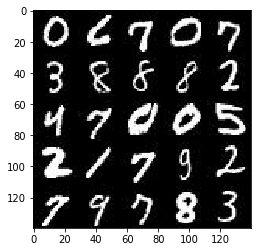

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

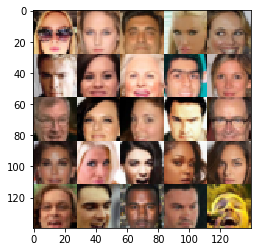

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [0]:
from copy import deepcopy
from unittest import mock
import tensorflow as tf


def test_safe(func):
    """
    Isolate tests
    """
    def func_wrapper(*args):
        with tf.Graph().as_default():
            result = func(*args)
        print('Tests Passed')
        return result

    return func_wrapper


def _assert_tensor_shape(tensor, shape, display_name):
    assert tf.assert_rank(tensor, len(shape), message='{} has wrong rank'.format(display_name))

    tensor_shape = tensor.get_shape().as_list() if len(shape) else []

    wrong_dimension = [ten_dim for ten_dim, cor_dim in zip(tensor_shape, shape)
                       if cor_dim is not None and ten_dim != cor_dim]
    assert not wrong_dimension, \
        '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)


def _check_input(tensor, shape, display_name, tf_name=None):
    assert tensor.op.type == 'Placeholder', \
        '{} is not a Placeholder.'.format(display_name)

    _assert_tensor_shape(tensor, shape, 'Real Input')

    if tf_name:
        assert tensor.name == tf_name, \
            '{} has bad name.  Found name {}'.format(display_name, tensor.name)


class TmpMock():
    """
    Mock a attribute.  Restore attribute when exiting scope.
    """
    def __init__(self, module, attrib_name):
        self.original_attrib = deepcopy(getattr(module, attrib_name))
        setattr(module, attrib_name, mock.MagicMock())
        self.module = module
        self.attrib_name = attrib_name

    def __enter__(self):
        return getattr(self.module, self.attrib_name)

    def __exit__(self, type, value, traceback):
        setattr(self.module, self.attrib_name, self.original_attrib)


@test_safe
def test_model_inputs(model_inputs):
    image_width = 28
    image_height = 28
    image_channels = 3
    z_dim = 100
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)

    _check_input(input_real, [None, image_width, image_height, image_channels], 'Real Input')
    _check_input(input_z, [None, z_dim], 'Z Input')
    _check_input(learn_rate, [], 'Learning Rate')


@test_safe
def test_discriminator(discriminator, tf_module):
    with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
        image = tf.placeholder(tf.float32, [None, 28, 28, 3])

        output, logits = discriminator(image)
        _assert_tensor_shape(output, [None, 1], 'Discriminator Training(reuse=false) output')
        _assert_tensor_shape(logits, [None, 1], 'Discriminator Training(reuse=false) Logits')
        assert mock_variable_scope.called,\
            'tf.variable_scope not called in Discriminator Training(reuse=false)'
        assert mock_variable_scope.call_args == mock.call('discriminator', reuse=False), \
            'tf.variable_scope called with wrong arguments in Discriminator Training(reuse=false)'

        mock_variable_scope.reset_mock()

        output_reuse, logits_reuse = discriminator(image, True)
        _assert_tensor_shape(output_reuse, [None, 1], 'Discriminator Inference(reuse=True) output')
        _assert_tensor_shape(logits_reuse, [None, 1], 'Discriminator Inference(reuse=True) Logits')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Discriminator Inference(reuse=True)'
        assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True), \
            'tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)'


@test_safe
def test_generator(generator, tf_module):
    with TmpMock(tf_module, 'variable_scope') as mock_variable_scope:
        z = tf.placeholder(tf.float32, [None, 100])
        out_channel_dim = 5

        output = generator(z, out_channel_dim)
        _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=True)')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Generator Training(reuse=false)'
        assert mock_variable_scope.call_args == mock.call('generator', reuse=False), \
            'tf.variable_scope called with wrong arguments in Generator Training(reuse=false)'

        mock_variable_scope.reset_mock()
        output = generator(z, out_channel_dim, False)
        _assert_tensor_shape(output, [None, 28, 28, out_channel_dim], 'Generator output (is_train=False)')
        assert mock_variable_scope.called, \
            'tf.variable_scope not called in Generator Inference(reuse=True)'
        assert mock_variable_scope.call_args == mock.call('generator', reuse=True), \
            'tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)'


@test_safe
def test_model_loss(model_loss):
    out_channel_dim = 4
    input_real = tf.placeholder(tf.float32, [None, 28, 28, out_channel_dim])
    input_z = tf.placeholder(tf.float32, [None, 100])

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)

    _assert_tensor_shape(d_loss, [], 'Discriminator Loss')
    _assert_tensor_shape(g_loss, [], 'Generator Loss')


@test_safe
def test_model_opt(model_opt, tf_module):
    with TmpMock(tf_module, 'trainable_variables') as mock_trainable_variables:
        with tf.variable_scope('discriminator'):
            discriminator_logits = tf.Variable(tf.zeros([3, 3]))
        with tf.variable_scope('generator'):
            generator_logits = tf.Variable(tf.zeros([3, 3]))

        mock_trainable_variables.return_value = [discriminator_logits, generator_logits]
        d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits,
            labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=generator_logits,
            labels=[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]))
        learning_rate = 0.001
        beta1 = 0.9

        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        assert mock_trainable_variables.called,\
            'tf.mock_trainable_variables not called'




In [10]:
#import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_dis = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'inputs')
    inputs_gen = tf.placeholder(tf.float32, [None, z_dim], name='z')
    l_r = tf.placeholder(tf.float32,None, name = 'learning_rate')
    return inputs_dis, inputs_gen, l_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, alpha=0.2, training=True ,reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
      l = 64
      layer_1 = tf.layers.conv2d(images, l, 5, 2, padding='same')
      layer_1 = tf.nn.leaky_relu(layer_1, alpha= alpha)
      
      l*=2
      
      layer_2 = tf.layers.conv2d(layer_1, l, 3,2,padding='same')
      layer_2 = tf.layers.batch_normalization(layer_2, training = training)
      layer_2 = tf.nn.leaky_relu(layer_2, alpha = alpha)
      
      l*=2
      
      layer_3 = tf.layers.conv2d(layer_2, l, 3, 2, padding='same')
      layer_3 = tf.layers.batch_normalization(layer_3, training = training)
      layer_3 = tf.nn.leaky_relu(layer_3, alpha= alpha)
      
      l*=2
      
      layer_4 = tf.layers.conv2d(layer_3, l, 4, 1, padding = 'valid')
      layer_4 = tf.layers.batch_normalization(layer_4, training = training)
      layer_4 = tf.nn.leaky_relu(layer_4, alpha = alpha)
      
      flat = tf.reshape(layer_4,(-1,4*4*l))
      logits = tf.layers.dense(flat, 1, activation=None)
      output = tf.nn.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#test_discriminator(discriminator, tf)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [0]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator'):
      l=1024
      inputs = tf.layers.dense(z, 4*4*l)
      layer_1 = tf.reshape(inputs, (-1,4,4,l))
      layer_1 = tf.layers.batch_normalization(layer_1)
      layer_1 = tf.nn.relu(layer_1)
      
      layer_2 = tf.layers.conv2d_transpose()
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [0]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [0]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.